# Boston meets Seattle

As part of my Udacity Data Science Nanodegree program, I took a closer look at Airbnb’s two date sets from Seattle and Boston to find answers to the following questions:

But what exactly are the criteria here that influence travelers from around the world to ultimately book a trip to the big wide world? More precise:
    - What impact does travel time have on lodging prices?
    - Is it really positive to be ranked as a superhost on Airbnb?
    - What differences can be identified between the two cities of Seattle and Boston?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import AllTogether as t
import seaborn as sns

%matplotlib inline

#loading seattle dataset
df_s_cal = pd.read_csv('seattle_calendar.csv')
df_s_lis = pd.read_csv('seattle_listings.csv')
df_s_rev = pd.read_csv('seattle_reviews.csv')

#loading boston dataset
df_b_cal = pd.read_csv('boston_calendar.csv')
df_b_lis = pd.read_csv('boston_listings.csv')
df_b_rev = pd.read_csv('boston_reviews.csv')

#### Data preparation

Create a season column for the Calendar dataset

In [2]:
def create_season_column(df):
    '''
    This function creates a new column called "season" based on the month of the date.
    
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    df - pandas dataframe from input with a new column "season"
    '''
    df["date_month"] = df["date"].apply(lambda x: int(x.split("-")[1]))
    # create a list of conditions
    conditions = [
        (df['date_month'] == 12) | (df['date_month'] == 1) | (df['date_month'] == 2),
        (df['date_month'] == 3) | (df['date_month'] == 4) | (df['date_month'] == 5),
        (df['date_month'] == 6) | (df['date_month'] == 7) | (df['date_month'] == 8),
        (df['date_month'] == 9) | (df['date_month'] == 10) | (df['date_month'] == 11)
        ]

    # create a list of the values we want to assign for each condition
    values = ['winter', 'spring', 'summer', 'fall']

    # create a new column and use np.select to assign values to it using our lists as arguments
    df['season'] = np.select(conditions, values)
    
    return df

In [3]:
def make_col_to_float(df, colname):
    '''
    This function converts a string column for quantitative data into float values.
    
    INPUT
    df - pandas dataframe
    colname - name of the string column you want to change 
    
    OUTPUT
    df - pandas dataframe from input with converted column
    '''
    for c in colname:
        new_colname = c + "_float"
        df[new_colname] = df[c].str.replace('$', '')
        df[new_colname] = df[new_colname].str.replace(',', '').astype(float)    
    return df

Calendar, including listing id and the price and availability for that day

In [4]:
df_b_cal_new = create_season_column(df_b_cal)
df_s_cal_new = create_season_column(df_s_cal)

In [5]:
df_b_cal_new = df_b_cal_new.dropna()
df_s_cal_new = df_s_cal_new.dropna()

In [6]:
df_b_cal_new.columns

Index(['listing_id', 'date', 'available', 'price', 'date_month', 'season'], dtype='object')

Make column 'price' to a float type, so we can use this values for further analysis

In [7]:
col_list2 = ['price']

make_col_to_float(df_b_cal_new, col_list2)
make_col_to_float(df_s_cal_new, col_list2)

df_b_cal_new.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


listing_id        date available   price  date_month  season  price_float
365     3075044  2017-08-22         t  $65.00           8  summer         65.0
366     3075044  2017-08-21         t  $65.00           8  summer         65.0
367     3075044  2017-08-20         t  $65.00           8  summer         65.0
368     3075044  2017-08-19         t  $75.00           8  summer         75.0
369     3075044  2017-08-18         t  $75.00           8  summer         75.0

In [8]:
df_price_per_listing = df_b_cal_new.groupby(['listing_id']).mean()['price_float'].sort_values()
df_price_per_listing.head()

listing_id
12736032    11.000000
14867747    20.000000
14682145    25.000000
12074204    27.000000
8238078     28.410959
Name: price_float, dtype: float64

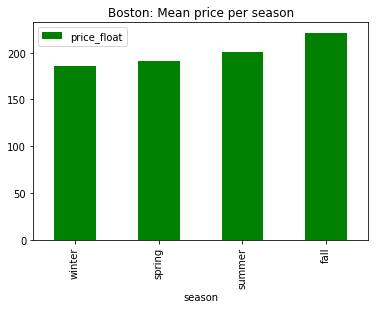

In [35]:
#Boston price per season
df_b_season = df_b_cal_new.groupby(['season']).mean()['price_float'].sort_values()
df_b_season.plot(kind='bar', title='Boston: Mean price per season', legend=True, colormap='ocean');

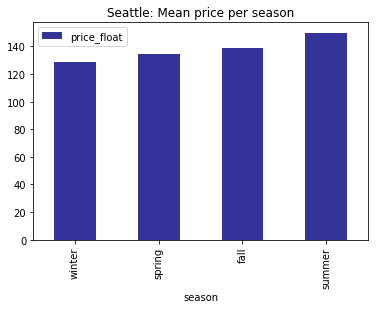

In [34]:
#Seattle price per season
df_s_season = df_s_cal_new.groupby(['season']).mean()['price_float'].sort_values()
df_s_season.plot(kind='bar', title='Seattle: Mean price per season', legend=True, colormap='terrain');

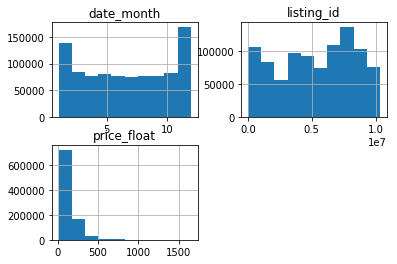

In [85]:
df_s_cal_new.hist();

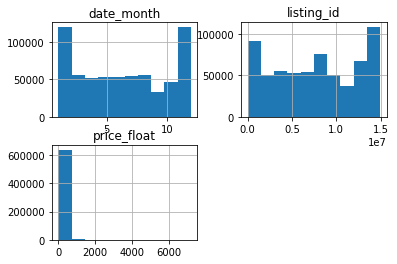

In [83]:
df_b_cal_new.hist();

## Data Modeling
#### Listing data
Selecting most interesting columns from big dataset

In [37]:
df_b_lis_edit = df_b_lis[['space','description','city','host_is_superhost', 'property_type', 'square_feet',
       'price', 'weekly_price', 'monthly_price',
       'cleaning_fee', 'number_of_reviews', 'review_scores_value']]

df_s_lis_edit = df_s_lis[['space','description','city','host_is_superhost', 'property_type', 'square_feet',
       'price', 'weekly_price', 'monthly_price',
       'cleaning_fee', 'number_of_reviews', 'review_scores_value']]

Columns with prices are not readable because there are Strings and not numeric. That's why, in the following, I will convert numeric columns to float values using implemented function make_col_to_float.

In [38]:
col_list1 = ["price","weekly_price","monthly_price","cleaning_fee"]

make_col_to_float(df_b_lis_edit, col_list1)
make_col_to_float(df_s_lis_edit, col_list1)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


space  \
0     Make your self at home in this charming one-be...   
1     Beautiful, hypoallergenic apartment in an extr...   
2     Our house is modern, light and fresh with a wa...   
3                                                   NaN   
4     Cozy family craftman house in beautiful neighb...   
5     If you include a bit of your background in you...   
6     Enjoy a quiet stay in our comfortable 1915 Cra...   
7      This cabin was built with Airbnb in mind, Que...   
8     Located in the heart of the city, this space i...   
9     What's special about this place? A beautiful r...   
10    Be close to everything!  Queen Anne Hill is a ...   
11    Beautiful home in an extremely walkable neighb...   
12    This apartment is in a quiet and friendly city...   
13    Originally built in 1906, our house has a ligh...   
14    Gorgeous, LIGHT FILLED, Newly Constructed Mode...   
15    The Space This is a 1000 square foot, two bedr...   
16    **PLEASE MAKE SURE TO READ ALL INFO BEFORE BOO...   
17    French Country style home built in 1939 with s...   
18                                                  NaN   
19    This home encompasses the character that is so...   
20    Kitchen has hot water tap and sodastream Excel...   
21    Updated daylight basement space with queen and...   
22    Centrally located spacious home in the heart o...   
23    The space we are renting is the entire lower l...   
24    Step into the main living space with sitting a...   
25    Our home is a brick tudor/cottage built in 193...   
26    One bedroom has a queen sized bed, and the oth...   
27    The Spruce Kaboose is a hand built one of a ki...   
28    You won't want to leave your home away from ho...   
29    During the summer, there was construction on t...   
...                                                 ...   
3788  Our apartment is brand new construction with t...   
3789  Vintage, modern 1910 craftsman with dark expos...   
3790  The house was built in 1906 by the Seattle Lum...   
3791  This is a ground floor bedroom in our townhous...   
3792                                                NaN   
3793  Private, just-built, high-end studio loft in a...   
3794  Enter via the big back deck which has views of...   
3795  This historic building houses a converted stor...   
3796  Charming and pristine pied-a-terre in the mids...   
3797  A clean and simple mother-in-law basement stud...   
3798  New, modern, clean, quiet and no clutter, yet ...   
3799                                                NaN   
3800  Each suite is 900 square feet of luxury and el...   
3801  Our recently renovated apartment is perfect fo...   
3802  In a land ruled by condos, it's hard to find a...   
3803  The space is well suited for large groups and ...   
3804  A lush, private garden path leads to the entra...   
3805  The Space This 2 bedroom, 1 bath garden-level ...   
3806                                                NaN   
3807  The studio is filled with beautiful original a...   
3808  This is a classically beautiful Craftsman home...   
3809  This one bedroom apartment (Hippy Shack) is de...   
3810  1200 ft2 2BR, 1 Bath farmhouse with a large, t...   
3811  The building is older (1970's) so not the mode...   
3812  The 1-bedroom, ground-floor Roots apartment is...   
3813  Our 3BR/2BA house bright, stylish, and wheelch...   
3814  This space has a great view of Portage Bay wit...   
3815                                                NaN   
3816  Fully furnished unit to accommodate most needs...   
3817                                                NaN   

                                            description     city  \
0     Make your self at home in this charming one-be...  Seattle   
1     Chemically sensitive? We've removed the irrita...  Seattle   
2     New modern house built in 2013.  Spectacular s...  Seattle   
3     A charming apartment that sits atop Queen Anne...  Seattle   
4     Cozy family craftman house in beautiful neigh

Delete old numeric columns and use newly created _float columns

In [39]:
df_b_lis_edit = df_b_lis_edit[['space','description','city','host_is_superhost', 'property_type', 'square_feet',
       'price_float', 'weekly_price_float', 'monthly_price_float',
       'cleaning_fee_float', 'number_of_reviews', 'review_scores_value']]

df_s_lis_edit = df_s_lis_edit[['space','description','city','host_is_superhost', 'property_type', 'square_feet',
       'price_float', 'weekly_price_float', 'monthly_price_float',
       'cleaning_fee_float', 'number_of_reviews', 'review_scores_value']]

In the listing dataframe, we have categorical ('city','host_is_superhost', 'property_type') and numeric values ('square_feet', 'price_float', 'weekly_price_float', 'monthly_price_float','cleaning_fee_float', 'number_of_reviews','review_scores_value').

In the following, I will fill numeric values that are null with the mean with the benefit that the sample mean for that variable is not changing. For categorical, I will build dummy variables including na to not impose a rank of the categories and to have on the other hand the ability to interpret the results more easily than other encodings.

In [40]:
#boston
num_vars = df_b_lis_edit.select_dtypes(include=['float', 'int']).columns
for col in num_vars:
    df_b_lis_edit[col].fillna((df_b_lis_edit[col].mean()), inplace=True)

In [41]:
#seattle
num_vars = df_s_lis_edit.select_dtypes(include=['float', 'int']).columns
for col in num_vars:
    df_s_lis_edit[col].fillna((df_s_lis_edit[col].mean()), inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


## Evlaution of the results

Histogram of Bostons metrics

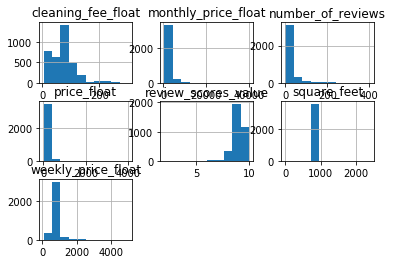

In [80]:
df_b_lis_edit.hist();

Histogram of Bostons metrics

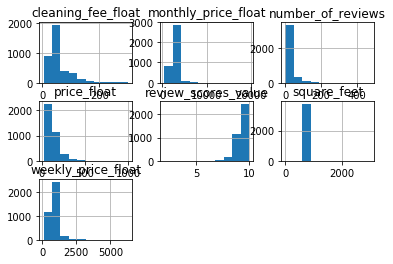

In [81]:
df_s_lis_edit.hist();

Heatmap of Seattle metrics

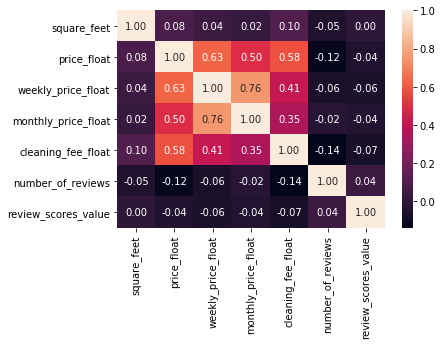

In [78]:
sns.heatmap(df_s_lis_edit.corr(), annot=True, fmt=".2f");

Heatmap of Bostons metrics

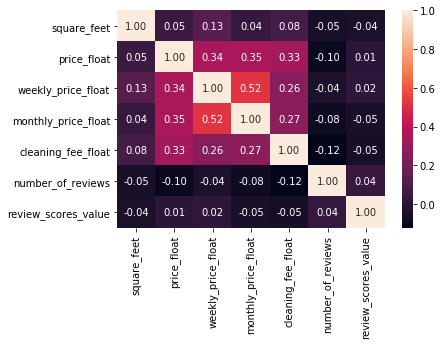

In [82]:
sns.heatmap(df_b_lis_edit.corr(), annot=True, fmt=".2f");

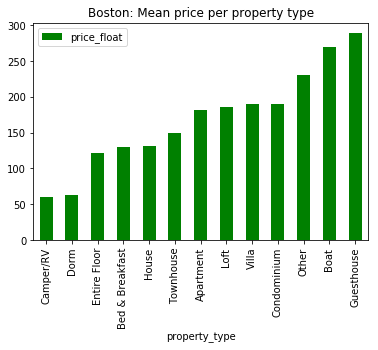

In [42]:
df_b_prop = df_b_lis_edit.groupby(['property_type']).mean()['price_float'].sort_values()
df_b_prop.plot(kind='bar', title='Boston: Mean price per property type', legend=True, colormap='ocean');

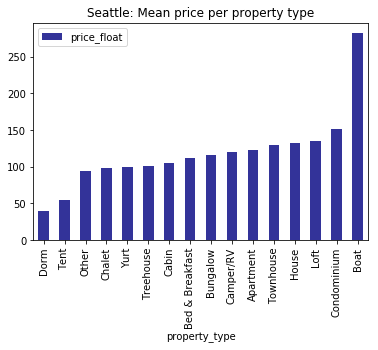

In [44]:
df_s_prop = df_s_lis_edit.groupby(['property_type']).mean()['price_float'].sort_values()
df_s_prop.plot(kind='bar', title='Seattle: Mean price per property type', legend=True, colormap='terrain');

Does being a superhost have any effect on the price of the property?

In [50]:
df_b_lis_edit.groupby(['host_is_superhost']).mean()['price_float'].sort_values()

host_is_superhost
f    173.604468
t    176.434889
Name: price_float, dtype: float64

In [51]:
df_s_lis_edit.groupby(['host_is_superhost']).mean()['price_float'].sort_values()

host_is_superhost
f    127.391376
t    130.140103
Name: price_float, dtype: float64

Does being a superhost have any effect on the review score of the property?

In [52]:
df_b_lis_edit.groupby(['host_is_superhost']).mean()['review_scores_value'].sort_values()

host_is_superhost
f    9.099727
t    9.703162
Name: review_scores_value, dtype: float64

In [53]:
df_s_lis_edit.groupby(['host_is_superhost']).mean()['review_scores_value'].sort_values()

host_is_superhost
f    9.378722
t    9.739345
Name: review_scores_value, dtype: float64

In [42]:
# df_b_lis_edit.head()

In [61]:
df_b_lis_small = df_b_lis_edit.drop(['space','description','number_of_reviews','weekly_price_float','monthly_price_float','cleaning_fee_float'], axis=1)
df_s_lis_small = df_s_lis_edit.drop(['space','description','number_of_reviews','weekly_price_float','monthly_price_float','cleaning_fee_float'], axis=1)
df_s_lis_small.head()

city host_is_superhost property_type  square_feet  price_float  \
0  Seattle                 f     Apartment   854.618557         85.0   
1  Seattle                 t     Apartment   854.618557        150.0   
2  Seattle                 f         House   854.618557        975.0   
3  Seattle                 f     Apartment   854.618557        100.0   
4  Seattle                 f         House   854.618557        450.0   

   review_scores_value  
0            10.000000  
1            10.000000  
2            10.000000  
3             9.452245  
4             9.000000

In [56]:
# df_b_lis_small.select_dtypes(include=['object'])

In [44]:
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [62]:
#Boston | Pull a list of the column names of the categorical variables 
cat_df_b = df_b_lis_small.select_dtypes(include=['object'])
cat_cols_lst_b = cat_df_b.columns

#Seattle | Pull a list of the column names of the categorical variables 
cat_df_s = df_s_lis_small.select_dtypes(include=['object'])
cat_cols_lst_s = cat_df_s.columns

#df_b_lis_dummy = create_dummy_df(df_b_lis_edit, cat_cols_lst, dummy_na=False) #Use your newly created function

# Show a header of df_new to check
#print(df_b_lis_dummy.shape)

In [63]:
cat_cols_lst_b

Index(['city', 'host_is_superhost', 'property_type'], dtype='object')

Build funtion to clean the data, fit the model, predict and score the data

In [64]:
def clean_fit_linear_mod(df, response_col, cat_cols, dummy_na, test_size=.3, rand_state=42):
    '''
    INPUT:
    df - a dataframe holding all the variables of interest
    response_col - a string holding the name of the column 
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    test_size - a float between [0,1] about what proportion of data should be in the test dataset
    rand_state - an int that is provided as the random state for splitting the data into training and test 
    
    OUTPUT:
    test_score - float - r2 score on the test data
    train_score - float - r2 score on the test data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    
    Your function should:
    1. Drop the rows with missing response values
    2. Drop columns with NaN for all the values
    3. Use create_dummy_df to dummy categorical columns
    4. Fill the mean of the column for any missing values 
    5. Split your data into an X matrix and a response vector y
    6. Create training and test sets of data
    7. Instantiate a LinearRegression model with normalized data
    8. Fit your model to the training data
    9. Predict the response for the training data and the test data
    10. Obtain an rsquared value for both the training and test data
    '''
    #Drop the rows with missing response values
    df  = df.dropna(subset=[response_col], axis=0)

    #Drop columns with all NaN values
    df = df.dropna(how='all', axis=1)

    #Dummy categorical variables
    df = create_dummy_df(df, cat_cols, dummy_na)

    # Mean function
    fill_mean = lambda col: col.fillna(col.mean())
    # Fill the mean
    df = df.apply(fill_mean, axis=0)

    #Split into explanatory and response variables
    X = df.drop(response_col, axis=1)
    y = df[response_col]

    #Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=rand_state)

    lm_model = LinearRegression(normalize=True) # Instantiate
    lm_model.fit(X_train, y_train) #Fit

    #Predict using your model
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    #Score using your model
    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [69]:
#Test your function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(df_b_lis_small, 'price_float', cat_cols_lst_b, dummy_na=False)

In [71]:
#Test your function with the above dataset
test_score, train_score, lm_model, X_train, X_test, y_train, y_test = clean_fit_linear_mod(df_s_lis_small, 'price_float', cat_cols_lst_s, dummy_na=False)

In [72]:
#Print training and testing score
print("The rsquared on the training data was {}.  The rsquared on the test data was {}.".format(train_score, test_score))

The rsquared on the training data was 0.02283189745217773.  The rsquared on the test data was 0.01972138286857472.
